Usefull sources

https://ar5iv.labs.arxiv.org/html/1907.02724

https://www.kaggle.com/code/shovalt/crowd-counting-keras-pretrained-resnet50-cnn/notebook



In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, Activation, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import vgg16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import numpy as np
import os
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import os

GOOGLE_DRIVE_TRAINING_PATH_AFTER_MYDRIVE = 'AI_Project_Files/Filtered_Training'
GOOGLE_DRIVE_TESTING_PATH_AFTER_MYDRIVE = 'AI_Project_Files/Filtered_Testing'

GOOGLE_DRIVE_TRAINING_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_TRAINING_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_TESTING_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_TESTING_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_TRAINING_PATH))
print(os.listdir(GOOGLE_DRIVE_TESTING_PATH))

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
['seq_000525.jpg', 'seq_000518.jpg', 'seq_000502.jpg', 'seq_000493.jpg', 'seq_000494.jpg', 'seq_000495.jpg', 'seq_000496.jpg', 'seq_000503.jpg', 'seq_000497.jpg', 'seq_000492.jpg', 'seq_000490.jpg', 'seq_000501.jpg', 'seq_000498.jpg', 'seq_000491.jpg', 'seq_000480.jpg', 'seq_000475.jpg', 'seq_000473.jpg', 'seq_000472.jpg', 'seq_000476.jpg', 'seq_000489.jpg', 'seq_000479.jpg', 'seq_000438.jpg', 'seq_000434.jpg', 'seq_000436.jpg', 'seq_000426.jpg', 'seq_000428.jpg', 'seq_000427.jpg', 'seq_000443.jpg', 'seq_000435.jpg', 'seq_000442.jpg', 'seq_000477.jpg', 'seq_000474.jpg', 'seq_000470.jpg', 'seq_000405.jpg', 'seq_000412.jpg', 'seq_000411.jpg', 'seq_000404.jpg', 'seq_000423.jpg', 'seq_000418.jpg', 'seq_000416.jpg', 'seq_000410.jpg', 'seq_000433.jpg', 'seq_000478.jpg', 'seq_000413.jpg', 'seq_000425.jpg', 'seq_000420.jpg', 'seq_000421.jpg', 'seq_000422.jpg', 'seq

In [ ]:
GOOGLE_DRIVE_TRAINING_LABELS_PATH_AFTER_MYDRIVE = 'AI_Project_Files/filtered_training_csvfile.csv'
GOOGLE_DRIVE_TESTING_LABELS_PATH_AFTER_MYDRIVE = 'AI_Project_Files/filtered_testing_csvfile.csv'

GOOGLE_DRIVE_TRAINING_LABELS_PATH =  os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_TRAINING_LABELS_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_TESTING_LABELS_PATH =  os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_TESTING_LABELS_PATH_AFTER_MYDRIVE)

**Paths for Training**
- Images Folder: `GOOGLE_DRIVE_TRAINING_PATH`
- Labels File: `GOOGLE_DRIVE_TRAINING_LABELS_PATH`

**Paths for Testing**
- Images Folder: `GOOGLE_DRIVE_TESTING_PATH`
- Labels File: `GOOGLE_DRIVE_TESTING_LABELS_PATH`

In [ ]:
# loading training dataset
df = pd.read_csv(GOOGLE_DRIVE_TRAINING_LABELS_PATH)


In [ ]:
# add the image name column for every row
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format) # uncomment for training
#df['image_name'] = (df['id']+1).map('seq_{:06d}.jpg'.format) # uncomment for testing

def getClass(classification):
  if (classification == 'Crowded'):
    return 1
  return 0

# add a binary 0/1 class to each row
df['class'] = df['Classification'].map(getClass) # uncomment for training

print(df)

       id Classification      image_name  class
0     404    Not Crowded  seq_000404.jpg      0
1     405    Not Crowded  seq_000405.jpg      0
2     410        Crowded  seq_000410.jpg      1
3     411        Crowded  seq_000411.jpg      1
4     412        Crowded  seq_000412.jpg      1
..    ...            ...             ...    ...
945  1989    Not Crowded  seq_001989.jpg      0
946  1990    Not Crowded  seq_001990.jpg      0
947  1998    Not Crowded  seq_001998.jpg      0
948  1999    Not Crowded  seq_001999.jpg      0
949  2000    Not Crowded  seq_002000.jpg      0

[950 rows x 4 columns]


In [ ]:
df['Classification'].describe()


count         950
unique          2
top       Crowded
freq          538
Name: Classification, dtype: object

In [ ]:
size = 224
batch_size = 64

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=GOOGLE_DRIVE_TRAINING_PATH,
    x_col='image_name',
    y_col='Classification',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=GOOGLE_DRIVE_TRAINING_PATH,
    x_col='image_name',
    y_col='Classification',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 760 validated image filenames belonging to 2 classes.
Found 190 validated image filenames belonging to 2 classes.


In [ ]:
def load_vgg16(input_shape):
    # this loads VGG16 with weights learned by training on imagenet dataset.
    base_model = vgg16.VGG16(weights='imagenet', # Load the pretrained weights, trained on the ImageNet dataset.
                             include_top=False, # We don't include the fully-connected layer at the top of the network - we need to modify the top.
                             input_shape=input_shape)
    return base_model


In [ ]:
def create_crowd_counting_model(input_shape):
    base_model = load_vgg16(input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model


In [ ]:
input_shape = (size, size, 3)
model = create_crowd_counting_model(input_shape)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='BinaryCrossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(train_generator,
    epochs = 30,  # 50 epochs seems to have reached the minimal loss for this setup
    validation_data = valid_generator,
    verbose=2)

Epoch 1/30
12/12 - 54s - loss: 0.6345 - accuracy: 0.6592 - val_loss: 0.7748 - val_accuracy: 0.0947 - 54s/epoch - 4s/step
Epoch 2/30
12/12 - 17s - loss: 0.4810 - accuracy: 0.8395 - val_loss: 0.8211 - val_accuracy: 0.0947 - 17s/epoch - 1s/step
Epoch 3/30
12/12 - 19s - loss: 0.3741 - accuracy: 0.8592 - val_loss: 0.8684 - val_accuracy: 0.2158 - 19s/epoch - 2s/step
Epoch 4/30
12/12 - 17s - loss: 0.2928 - accuracy: 0.8842 - val_loss: 1.0208 - val_accuracy: 0.2000 - 17s/epoch - 1s/step
Epoch 5/30
12/12 - 17s - loss: 0.2529 - accuracy: 0.9145 - val_loss: 1.2055 - val_accuracy: 0.1579 - 17s/epoch - 1s/step
Epoch 6/30
12/12 - 18s - loss: 0.2478 - accuracy: 0.8961 - val_loss: 1.2727 - val_accuracy: 0.1421 - 18s/epoch - 1s/step
Epoch 7/30
12/12 - 17s - loss: 0.2294 - accuracy: 0.9026 - val_loss: 1.1729 - val_accuracy: 0.1947 - 17s/epoch - 1s/step
Epoch 8/30
12/12 - 19s - loss: 0.1935 - accuracy: 0.9224 - val_loss: 0.8879 - val_accuracy: 0.4000 - 19s/epoch - 2s/step
Epoch 9/30
12/12 - 17s - loss: 0

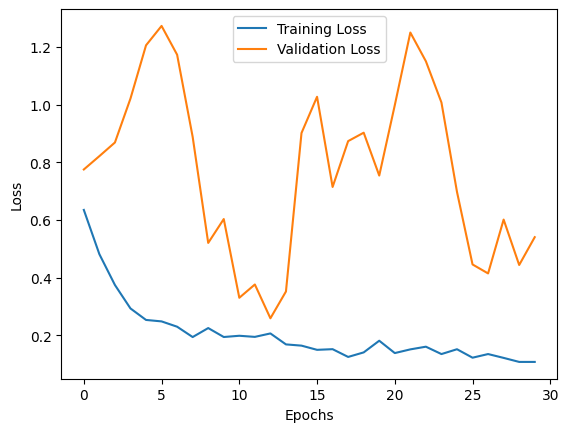

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
model.save("VGG16_Model.keras")

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255)
# Evaluate the model on the test set
test_df = pd.read_csv(GOOGLE_DRIVE_TESTING_LABELS_PATH)
test_df['image_name'] = test_df['id'].map('seq_{:06d}.jpg'.format) # assuming test labels are similar

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=GOOGLE_DRIVE_TESTING_PATH,
    x_col='image_name',
    y_col='Classification',
    target_size=(size, size),
    batch_size= batch_size,
    class_mode='binary',
    shuffle=False
)



Found 174 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 67 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Generate predictions and classification report
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).reshape(-1)

from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

print('Classification Report')
target_names = ['Not Crowded', 'Crowded']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

3/3 [==============================] - 9s 4s/step - loss: 0.1283 - accuracy: 0.9368
Test accuracy: 0.9367815852165222
3/3 [==============================] - 1s 364ms/step
Confusion Matrix
[[100  10]
 [  1  63]]
Classification Report
              precision    recall  f1-score   support

 Not Crowded       0.99      0.91      0.95       110
     Crowded       0.86      0.98      0.92        64

    accuracy                           0.94       174
   macro avg       0.93      0.95      0.93       174
weighted avg       0.94      0.94      0.94       174



In [ ]:
def load_and_preprocess_image(img_path, target_size):
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Model expects images in batches
    img_array = vgg16.preprocess_input(img_array)  # Preprocess the image as required by the model
    img_array /= 255
    return img_array

In [ ]:
def pred(im):
    img = load_and_preprocess_image(im, (size, size))
    predict = model.predict(img)
    return np.mean(predict)


In [ ]:
# not really accurate but good enough (:
pred(GOOGLE_DRIVE_TESTING_PATH + "/seq_000003.jpg")


1/1 [==============================] - 1s 1s/step


0.0020656686